# Parameter sweep for LBI predictor

Load flu tip attributes and final clade frequencies and then calculate the error of an exponential growth model based on just the LBI predictor across a range of predictor coefficients. The goal is to determine the shape of the error function that is exposed to scipy's optimization machinery.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

plt.style.use("huddlej")

In [2]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [3]:
sys.path.insert(0, "../src")

In [4]:
from fit_model import ExponentialGrowthModel
from forecast.metrics import mean_absolute_error, sum_of_squared_errors, negative_information_gain, add_pseudocounts_to_frequencies

## Load data

Define the range of possible coefficient values to explore.

In [5]:
coefficients = np.linspace(-3, 3, 21)

In [6]:
delta_time = 1.0
l1_lambda = 0.0

In [7]:
last_timepoint = pd.to_datetime("2016-10-01")

In [9]:
# Load tip attributes.
X = pd.read_csv(
    "../results/builds/h3n2/90_viruses_per_month/sample_0/2000-10-01--2015-10-01/tip_attributes_with_naive_predictor.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [10]:
X = X.loc[:, ["strain", "clade_membership", "timepoint", "cTiterSub_x", "lbi", "ep", "ep_x", "ne", "delta_frequency", "frequency"]].copy()

In [11]:
X = X[X["timepoint"] <= last_timepoint]

In [12]:
X.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency
0,A/BacGiang/BG003/2004,4ff1302,2004-10-01,NaN,0.031581,10,NaN,6,-0.057594,0.000508
1,A/BayofPlenty/383/2004,aaeb03c,2004-10-01,-5.521318,0.699128,12,-2.718854,7,0.296674,0.006026
2,A/California/7/2004,aaeb03c,2004-10-01,-5.521318,0.685431,14,-2.363422,7,0.296674,0.005733
3,A/California/NHRC0002/2003,4ff1302,2004-10-01,NaN,0.276634,10,NaN,6,-0.057594,0.000002
4,A/California/NHRC0003/2003,4ff1302,2004-10-01,NaN,0.275124,9,NaN,6,-0.057594,0.000002


In [12]:
X.shape

(13305, 10)

In [13]:
# Load final clade tip frequencies.
final_clade_frequencies = pd.read_csv(
    "../results/builds/h3n2/90_viruses_per_month/sample_0/2000-10-01--2015-10-01/final_clade_frequencies.tsv",
    sep="\t",
    parse_dates=["initial_timepoint", "final_timepoint"]
)

In [14]:
final_clade_frequencies.shape

(13022, 5)

In [15]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,4ff1302,2005-10-01,A/California/NHRC0009/2005,0.000270
1,2004-10-01,4ff1302,2005-10-01,A/California/NHRC0010/2005,0.000290
2,2004-10-01,4ff1302,2005-10-01,A/Hanoi/ISBM16/2005,0.002659
3,2004-10-01,4ff1302,2005-10-01,A/HongKong/CUHK6422/2005,0.000161
4,2004-10-01,4ff1302,2005-10-01,A/HongKong/CUHK6898/2005,0.000380


In [16]:
first_final_timepoint = final_clade_frequencies["final_timepoint"].min()

In [17]:
first_final_timepoint

Timestamp('2005-10-01 00:00:00')

Find all tips for the first final timepoint and afterwards. We want to exclude tips that preceded that first final timepoint because they are never considered in projections.

In [18]:
all_tips = X.loc[X["timepoint"] >= first_final_timepoint, ["strain", "clade_membership", "timepoint", "frequency"]].copy()

In [19]:
all_tips.head()

,strain,clade_membership,timepoint,frequency
599,A/Auckland/616/2005,6a436ac,2005-10-01,0.003560
600,A/Auckland/617/2005,6a436ac,2005-10-01,0.003649
601,A/Auckland/621/2005,7aa732d,2005-10-01,0.000149
602,A/Australia/NHRC0001/2005,6a436ac,2005-10-01,0.004401
603,A/Australia/NHRC0002/2005,6a436ac,2005-10-01,0.004564


In [20]:
all_tips.shape

(12706, 4)

In [21]:
all_and_final_tips = all_tips.merge(
    final_clade_frequencies,
    how="left",
    left_on=["timepoint", "strain"],
    right_on=["final_timepoint", "strain"],
    suffixes=["_original", ""]
)

In [22]:
all_and_final_tips.shape

(12706, 8)

In [23]:
all_and_final_tips.head()

,strain,clade_membership_original,timepoint,frequency_original,initial_timepoint,clade_membership,final_timepoint,frequency
0,A/Auckland/616/2005,6a436ac,2005-10-01,0.003560,2004-10-01,7aa732d,2005-10-01,0.003560
1,A/Auckland/617/2005,6a436ac,2005-10-01,0.003649,2004-10-01,7aa732d,2005-10-01,0.003649
2,A/Auckland/621/2005,7aa732d,2005-10-01,0.000149,2004-10-01,7aa732d,2005-10-01,0.000149
3,A/Australia/NHRC0001/2005,6a436ac,2005-10-01,0.004401,2004-10-01,7aa732d,2005-10-01,0.004401
4,A/Australia/NHRC0002/2005,6a436ac,2005-10-01,0.004564,2004-10-01,7aa732d,2005-10-01,0.004564


In [24]:
pd.isnull(all_and_final_tips["frequency"]).sum()

4

In [25]:
all_and_final_tips[pd.isnull(all_and_final_tips["frequency"])]["strain"].unique().shape

(4,)

In [26]:
for tip in all_and_final_tips.loc[pd.isnull(all_and_final_tips["frequency"]), ["strain"]].drop_duplicates().values:
    print(tip[0])

A/Astrakhan/RII06/2012
A/Omsk/RII02/2012
A/Omsk/RII06/2012
A/Singapore/KK581/2011


In [27]:
X.timepoint.unique()

array(['2004-10-01T00:00:00.000000000', '2005-04-01T00:00:00.000000000',
       '2005-10-01T00:00:00.000000000', '2006-04-01T00:00:00.000000000',
       '2006-10-01T00:00:00.000000000', '2007-04-01T00:00:00.000000000',
       '2007-10-01T00:00:00.000000000', '2008-04-01T00:00:00.000000000',
       '2008-10-01T00:00:00.000000000', '2009-04-01T00:00:00.000000000',
       '2009-10-01T00:00:00.000000000', '2010-04-01T00:00:00.000000000',
       '2010-10-01T00:00:00.000000000', '2011-04-01T00:00:00.000000000',
       '2011-10-01T00:00:00.000000000', '2012-04-01T00:00:00.000000000',
       '2012-10-01T00:00:00.000000000', '2013-04-01T00:00:00.000000000',
       '2013-10-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
       '2014-10-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [28]:
X.shape

(13305, 10)

In [29]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,4ff1302,2005-10-01,A/California/NHRC0009/2005,0.000270
1,2004-10-01,4ff1302,2005-10-01,A/California/NHRC0010/2005,0.000290
2,2004-10-01,4ff1302,2005-10-01,A/Hanoi/ISBM16/2005,0.002659
3,2004-10-01,4ff1302,2005-10-01,A/HongKong/CUHK6422/2005,0.000161
4,2004-10-01,4ff1302,2005-10-01,A/HongKong/CUHK6898/2005,0.000380


In [30]:
final_clade_frequencies.tail()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
13017,2015-10-01,aafb4e9,2016-10-01,NaN,0.0
13018,2015-10-01,414723b,2016-10-01,NaN,0.0
13019,2015-10-01,1a16e36,2016-10-01,NaN,0.0
13020,2015-10-01,c65d2b1,2016-10-01,NaN,0.0
13021,2015-10-01,c25ef77,2016-10-01,NaN,0.0


In [31]:
y = final_clade_frequencies.groupby([
    "initial_timepoint",
    "clade_membership"
])["frequency"].sum().reset_index()

y = y.rename(
    columns={"initial_timepoint": "timepoint"}
)

y = y[y["timepoint"] <= last_timepoint]

In [32]:
y.head()

,timepoint,clade_membership,frequency
0,2004-10-01,06ed3c7,0.000000
1,2004-10-01,31e4ba2,0.000000
2,2004-10-01,412c00a,0.000000
3,2004-10-01,44989e1,0.018695
4,2004-10-01,4952842,0.000000


In [33]:
y.groupby("timepoint")["frequency"].sum()

timepoint
2004-10-01    1.000002
2005-04-01    0.999993
2005-10-01    1.000001
2006-04-01    1.000022
2006-10-01    1.000025
2007-04-01    1.000012
2007-10-01    1.000005
2008-04-01    1.000007
2008-10-01    0.999998
2009-04-01    0.999989
2009-10-01    0.999999
2010-04-01    1.000014
2010-10-01    0.999981
2011-04-01    1.000019
2011-10-01    0.997606
2012-04-01    0.999994
2012-10-01    0.999995
2013-04-01    1.000038
2013-10-01    0.999939
2014-04-01    0.999943
2014-10-01    0.999963
2015-04-01    0.000000
2015-10-01    0.000000
Name: frequency, dtype: float64

In [34]:
X["frequency"].min()

1e-06

## Inspect LBI model

In [35]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

Calculate error for an LBI model across all coefficients.

In [36]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

In [37]:
min(errors)

7.111012939307097

In [38]:
coefficients[np.argmin(errors)]

0.5999999999999996

Text(0,0.5,'SSE')

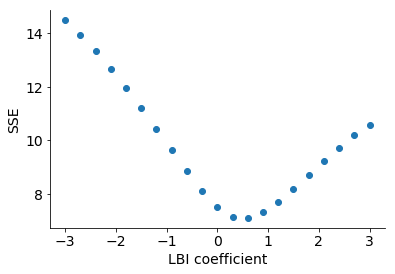

In [39]:
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("SSE")

Text(0,0.5,'Negative information gain')

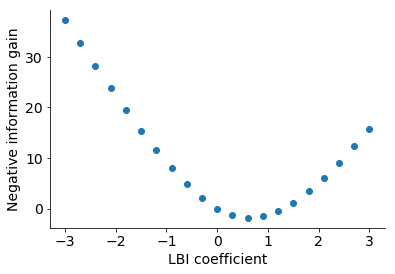

In [40]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("Negative information gain")

In [41]:
min(errors)

-1.853520057623594

In [42]:
coefficients[np.argmin(errors)]

0.5999999999999996

## Inspect cTiterSub model

In [ ]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [ ]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

In [ ]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("SSE")

In [ ]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("MAE")

## Inspect epitope count model

In [ ]:
predictors = ["ep"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [ ]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

In [ ]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("SSE")

In [ ]:
predictors = ["ep"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("MAE")

## Inspect epitope cross-immunity model

In [ ]:
predictors = ["ep_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("SSE")

In [ ]:
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("MAE")

## Inspect delta frequency model

In [ ]:
predictors = ["delta_frequency"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

In [ ]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

In [ ]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Delta frequency model coefficient")
plt.ylabel("MAE")

## Inspect two-parameter models

In [ ]:
predictors = ["lbi", "cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [ ]:
len(coefficients)

In [ ]:
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("SSE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [ ]:
predictors = ["lbi", "cTiterSub_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "cTiterSub": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
records_df = pd.DataFrame(records)
records_df.sort_values("error").head()

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("MAE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

## Minimize negative information gain

Add pseudocounts to current and future tip frequencies.

In [141]:
pseudocount = 1e-6
X_with_pseudocounts = add_pseudocounts_to_frequencies(X, pseudocount)
final_clade_frequencies_with_pseudocounts = add_pseudocounts_to_frequencies(
    final_clade_frequencies,
    pseudocount,
    timepoint_column="initial_timepoint"
)

In [142]:
y_with_pseudocounts = final_clade_frequencies_with_pseudocounts.groupby([
    "initial_timepoint",
    "clade_membership"
])["frequency"].sum().reset_index()

y_with_pseudocounts = y_with_pseudocounts.rename(
    columns={"initial_timepoint": "timepoint"}
)

#y_with_pseudocounts = y_with_pseudocounts[y_with_pseudocounts["timepoint"] <= last_timepoint]

In [143]:
X_with_pseudocounts.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency
0,A/BacGiang/BG003/2004,4ff1302,2004-10-01,2.107659,-1.179518,10,1.995151,6,-0.233467,0.000508
1,A/California/NHRC0002/2003,4ff1302,2004-10-01,2.107659,-0.494101,10,2.013158,6,-0.233467,0.000002
2,A/California/NHRC0003/2003,4ff1302,2004-10-01,2.107659,-0.498687,9,1.837884,6,-0.233467,0.000002
3,A/California/NHRC0004/2003,4ff1302,2004-10-01,2.107659,-0.507784,9,1.837884,6,-0.233467,0.000003
4,A/Christchurch/15/2004,4ff1302,2004-10-01,2.107659,-1.276597,12,2.323706,6,-0.233467,0.008018


In [144]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,4ff1302,2005-10-01,A/California/NHRC0009/2005,0.000267
1,2004-10-01,4ff1302,2005-10-01,A/California/NHRC0010/2005,0.000286
2,2004-10-01,4ff1302,2005-10-01,A/Hanoi/ISBM16/2005,0.002624
3,2004-10-01,4ff1302,2005-10-01,A/HongKong/HKU45/2005,0.001356
4,2004-10-01,4ff1302,2005-10-01,A/NewYork/243/2005,0.000185


In [145]:
final_clade_frequencies_with_pseudocounts.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,4ff1302,2005-10-01,A/California/NHRC0009/2005,0.000267
1,2004-10-01,4ff1302,2005-10-01,A/California/NHRC0010/2005,0.000286
2,2004-10-01,4ff1302,2005-10-01,A/Hanoi/ISBM16/2005,0.002624
3,2004-10-01,4ff1302,2005-10-01,A/HongKong/HKU45/2005,0.001356
4,2004-10-01,4ff1302,2005-10-01,A/NewYork/243/2005,0.000185


In [146]:
y_with_pseudocounts.head()

,timepoint,clade_membership,frequency
0,2004-10-01,06ed3c7,9.999820e-07
1,2004-10-01,31e4ba2,9.999820e-07
2,2004-10-01,412c00a,9.999820e-07
3,2004-10-01,44989e1,1.845367e-02
4,2004-10-01,4952842,9.999820e-07


Text(0,0.5,'Negative information gain')

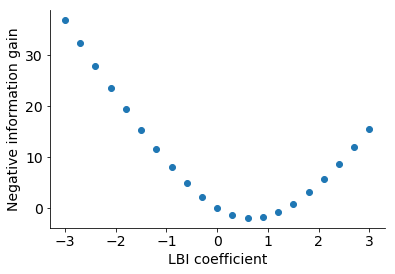

In [147]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X_with_pseudocounts, y_with_pseudocounts)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("Negative information gain")

In [148]:
min(errors)

-1.9543690340662125

In [149]:
coefficients[np.argmin(errors)]

0.5999999999999996

Text(0,0.5,'Negative information gain')

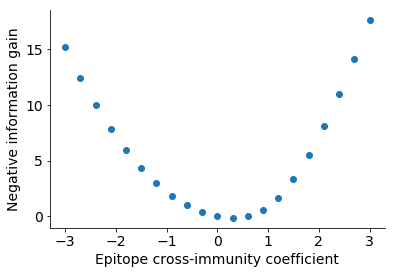

In [121]:
predictors = ["ep_x"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X_with_pseudocounts, y_with_pseudocounts)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity coefficient")
plt.ylabel("Negative information gain")

Text(0,0.5,'Negative information gain')

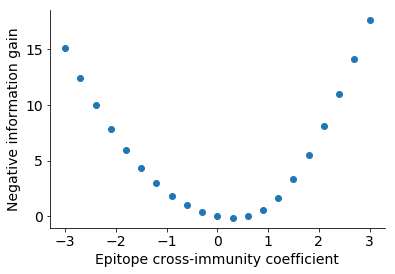

In [122]:
predictors = ["ep_x"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity coefficient")
plt.ylabel("Negative information gain")

In [27]:
predictors = ["lbi", "ep_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X_with_pseudocounts, y_with_pseudocounts)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "ep_x": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

Training error for coefficients [-3.0, -3.0]: 100.20858034238022
Training error for coefficients [-3.0, -2.7]: 94.88115178353684
Training error for coefficients [-3.0, -2.4]: 89.83308343913856
Training error for coefficients [-3.0, -2.1]: 85.07415713993974
Training error for coefficients [-3.0, -1.8]: 80.62085578658875
Training error for coefficients [-3.0, -1.5]: 76.49638622804389
Training error for coefficients [-3.0, -1.2000000000000002]: 72.73071704063906
Training error for coefficients [-3.0, -0.8999999999999999]: 69.36067166021121
Training error for coefficients [-3.0, -0.6000000000000001]: 66.4288979421243
Training error for coefficients [-3.0, -0.30000000000000027]: 63.98117046735106
Training error for coefficients [-3.0, 0.0]: 62.07117046072003
Training error for coefficients [-3.0, 0.2999999999999998]: 60.8107520246768
Training error for coefficients [-3.0, 0.5999999999999996]: 60.53060606933494
Training error for coefficients [-3.0, 0.8999999999999999]: 61.853781941650865
Tr

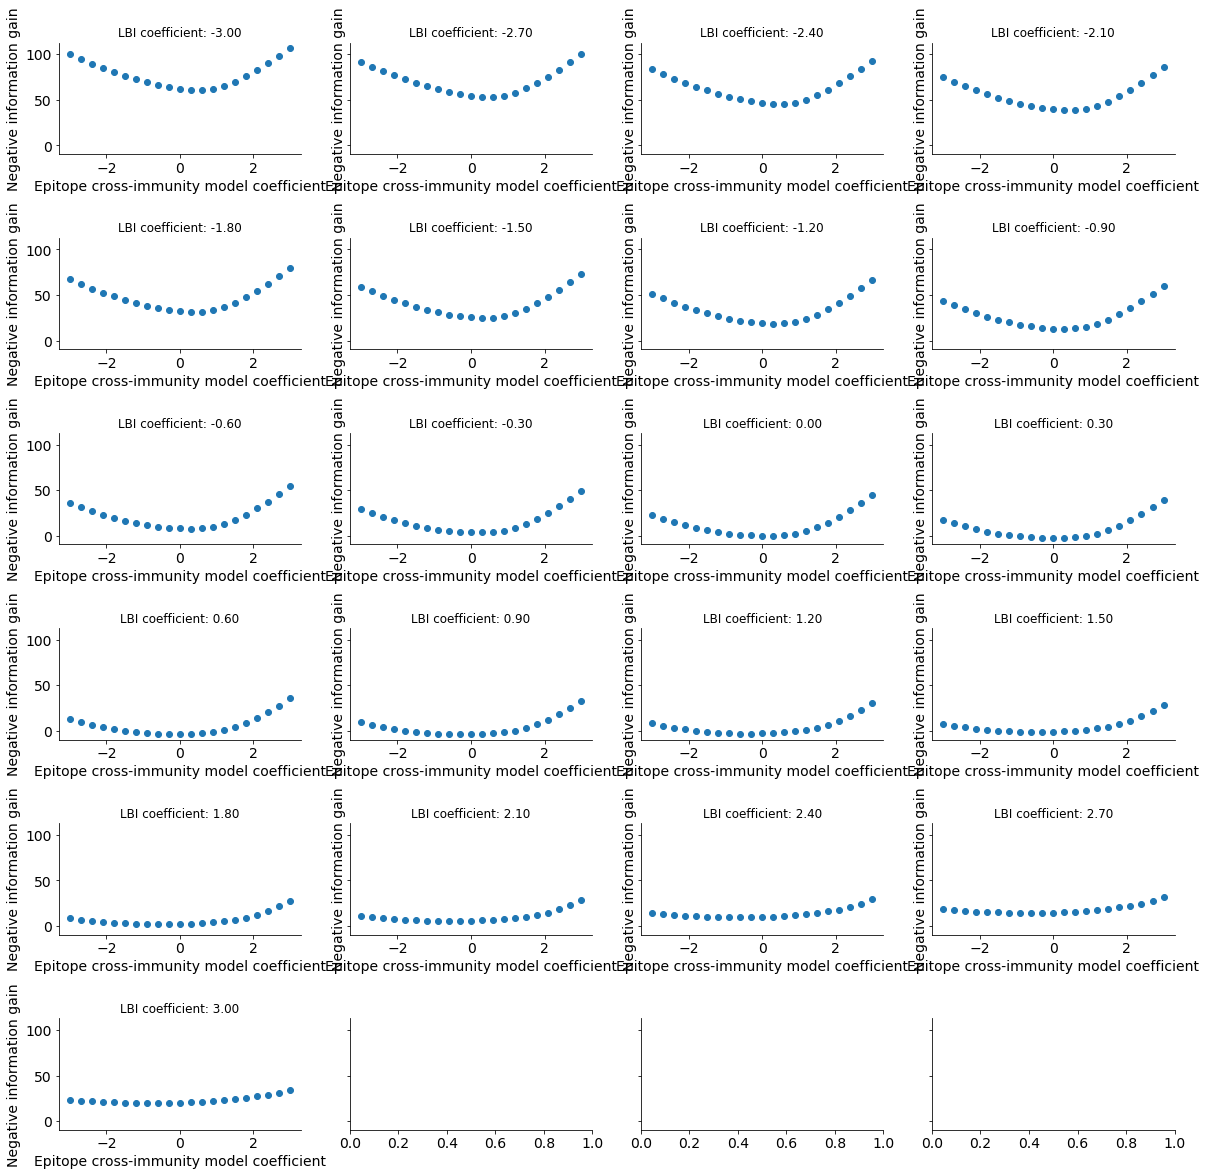

In [28]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Epitope cross-immunity model coefficient")
    ax.set_ylabel("Negative information gain")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [29]:
records_df = pd.DataFrame(records)
records_df.sort_values("error").head()

,ep_x,error,lbi
282,-0.3,-4.017556,0.9
283,0.0,-3.905799,0.9
281,-0.6,-3.821338,0.9
261,-0.3,-3.761840,0.6
262,0.0,-3.747511,0.6


## Sweep through L1 hyperparameters to find value that minimizes error

In [ ]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("Negative information gain")